In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# datatset is present at the kaggle which is saved in drive to save time.
#https://www.kaggle.com/competitions/ventilator-pressure-prediction/data
path='/content/drive/MyDrive/Bigdata/ventilator-pressure-prediction/'

In [3]:
import os
os.chdir(path)

In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=3d0ded87a0ed1acdbcbf1f601eda9442e2522befc466df049957a691c7a57d53
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
#importing all the necessory packages
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

In [6]:
# Create a SparkSession
spark = SparkSession.builder.config("spark.executor.resource.gpu.amount", "1").getOrCreate()
spark = SparkSession.builder.appName("regression").getOrCreate()

In [7]:
# Reading data from a CSV file
df = spark.read.csv("train.csv", header=True, inferSchema=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True)

In [8]:
# Show the first 5 rows of the DataFrame
df.show(5)

+---+---------+---+---+--------------------+-------------------+-----+------------------+
| id|breath_id|  R|  C|           time_step|               u_in|u_out|          pressure|
+---+---------+---+---+--------------------+-------------------+-----+------------------+
|  1|        1| 20| 50|                 0.0|0.08333400563464438|    0| 5.837491705069121|
|  2|        1| 20| 50|0.033652305603027344| 18.383041472634716|    0|5.9077938505203464|
|  3|        1| 20| 50| 0.06751441955566406| 22.509277769756217|    0| 7.876253923154396|
|  4|        1| 20| 50| 0.10154223442077637| 22.808822256996738|    0|11.742871922971284|
|  5|        1| 20| 50|  0.1357555389404297| 25.355850299494183|    0|12.234986941129785|
+---+---------+---+---+--------------------+-------------------+-----+------------------+
only showing top 5 rows



In [9]:
#Checking all column for null values and then dropping the null values.
columns_to_check = ['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']
df_without_null=df.na.drop(subset=columns_to_check)


In [10]:
df_without_null.printSchema()

root
 |-- id: integer (nullable = true)
 |-- breath_id: integer (nullable = true)
 |-- R: integer (nullable = true)
 |-- C: integer (nullable = true)
 |-- time_step: double (nullable = true)
 |-- u_in: double (nullable = true)
 |-- u_out: integer (nullable = true)
 |-- pressure: double (nullable = true)



In [11]:
# Extract unique values from R and C
# unique_R = df_without_null.select("R").distinct()
# unique_C = df_without_null.select("C").distinct()
# # Show the unique values
# unique_R.show()
# unique_C.show()
R=[20,5,50]
C=[20,10,50]

In [12]:
# Filter the dataset to include values up to breath_id =2
filtered_dataset = df_without_null.filter(col("breath_id") <=2)

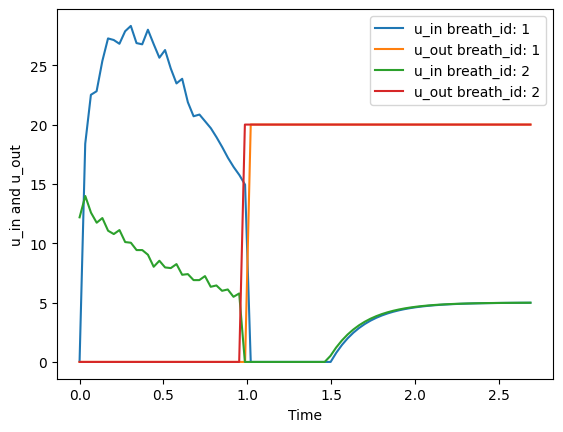

In [13]:
import matplotlib.pyplot as plt
# Create a figure and axis object for the plot
fig, ax = plt.subplots()

# Iterate over the breaths
for B_value in [1,2]:
# Filter the DataFrame for the current breath
  filtered_data = filtered_dataset.filter(filtered_dataset["breath_id"] == B_value)
# Extract the time,u_in, u_out
  time = [row["time_step"] for row in filtered_data.collect()]
  u_in = [row["u_in"] for row in filtered_data.collect()]
  u_out = [20*row["u_out"] for row in filtered_data.collect()] # uout is multiplied with 20 so it is visiabe in figure.
  ax.plot(time, u_in, label="u_in breath_id: {}".format(B_value))
  ax.plot(time, u_out, label="u_out breath_id: {}".format(B_value))
# Set the x-axis and y-axis labels
ax.set_xlabel("Time")
ax.set_ylabel("u_in and u_out")

# Add a legend
ax.legend()

# Show the plot
plt.show()

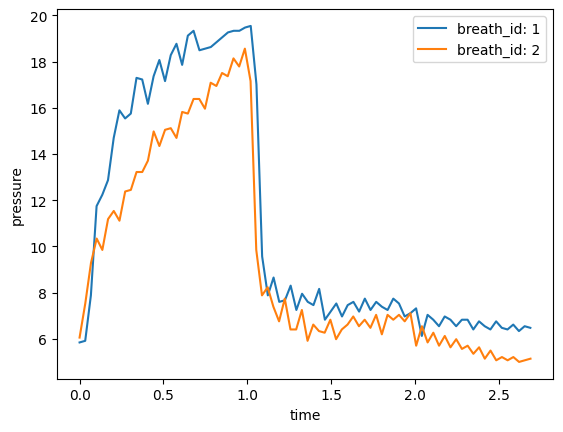

In [14]:

# Create a figure and axis object for the plot
fig, ax = plt.subplots()

# Iterate over the breaths
for B_value in [1,2]:
# Filter the DataFrame for the current breath
  filtered_data = filtered_dataset.filter(filtered_dataset["breath_id"] == B_value)
    # Extract the time and pressure columns from the filtered DataFrame
  time = [row["time_step"] for row in filtered_data.collect()]
  pressure=[row["pressure"] for row in filtered_data.collect()]
 # Plot the time vs pressure 
  ax.plot(time, pressure, label="breath_id: {}".format(B_value))
 #Set the x-axis and y-axis labels
  ax.set_xlabel("time")
  ax.set_ylabel("pressure")

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

In [15]:
# Filter the dataset to include values up to breath_id =2
filtered_dataset1 = df_without_null.filter(col("id") <=2000)


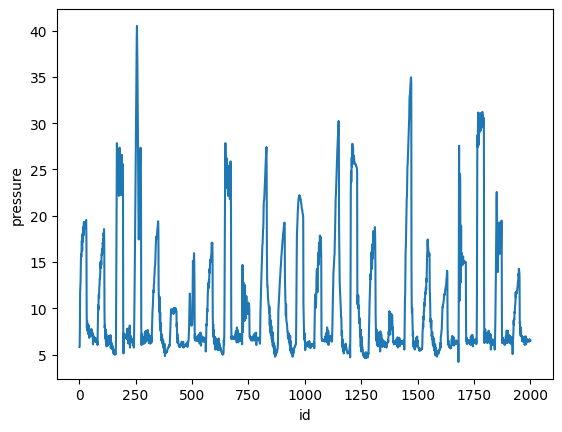

In [16]:
# Create a figure and axes
fig, ax = plt.subplots()
id = [row["id"] for row in filtered_dataset1.collect()]
pressure=[row["pressure"] for row in filtered_dataset1.collect()]
# Plot the data
ax.plot(id, pressure)
# Add labels and title
ax.set_xlabel('id')
ax.set_ylabel('pressure')
# Display the plot
plt.show()


In [17]:
# Create the MinMaxScaler transformer for pressure
assembler = VectorAssembler(inputCols=["pressure"], outputCol="pressure_vector")
df_without_null = assembler.transform(df_without_null)
p_scaler = MinMaxScaler(inputCol="pressure_vector", outputCol="scaled_pressure", min=0, max=1)
# Fit the transformer on the DataFrame
scaler_model = p_scaler.fit(df_without_null)
# Transform the DataFrame to scale the column
scaled_df = scaler_model.transform(df_without_null)
# The 'scaled_column' column contain the scaled values between 0 and 1
# scaled_df.show()

In [18]:
# Create the MinMaxScaler transformer for u_in
assembler = VectorAssembler(inputCols=["u_in"], outputCol="u_in_vector")
scaled_df = assembler.transform(scaled_df)
uin_scaler = MinMaxScaler(inputCol="u_in_vector", outputCol="scaled_u_in", min=0, max=1)
# Fit the transformer on the DataFrame
scaler_model = uin_scaler.fit(scaled_df)
# Transform the DataFrame to scale the column
scaled_df = scaler_model.transform(scaled_df)
# The 'scaled_column' column contain the scaled values between 0 and 1
scaled_df.show(5)

+---+---------+---+---+--------------------+-------------------+-----+------------------+--------------------+--------------------+--------------------+--------------------+
| id|breath_id|  R|  C|           time_step|               u_in|u_out|          pressure|     pressure_vector|     scaled_pressure|         u_in_vector|         scaled_u_in|
+---+---------+---+---+--------------------+-------------------+-----+------------------+--------------------+--------------------+--------------------+--------------------+
|  1|        1| 20| 50|                 0.0|0.08333400563464438|    0| 5.837491705069121| [5.837491705069121]|[0.11591148577449...|[0.08333400563464...|[8.33340056346443...|
|  2|        1| 20| 50|0.033652305603027344| 18.383041472634716|    0|5.9077938505203464|[5.9077938505203464]|[0.11696522655426...|[18.383041472634716]|[0.18383041472634...|
|  3|        1| 20| 50| 0.06751441955566406| 22.509277769756217|    0| 7.876253923154396| [7.876253923154396]|[0.14646996838777...

In [19]:
# dropping vectors which are created for the scaling purpose
scaled_df = scaled_df.drop('pressure_vector')
scaled_df = scaled_df.drop('u_in_vector')


In [20]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType

# Extract the value from the Vector column and cast it to Double
extract_value = udf(lambda v: float(v[0]), DoubleType())
# Add a new column by extracting values from scaled vectors.
df_with_double = scaled_df.withColumn('scaled_pressure_value', extract_value('scaled_pressure'))
df_with_double = df_with_double.withColumn('scaled_u_in_value', extract_value('scaled_u_in'))

In [21]:
# dropping scaled vectors.
df_with_double=df_with_double.drop('scaled_pressure')
df_with_double=df_with_double.drop('scaled_u_in')

In [22]:
# df_with_double.write.csv('scaled_dataset.csv',)

In [23]:
# from pyspark.sql.functions import max,min

# Take the minimum value from pressure column so predictions can be upscaled later.
# min_p = df_with_double.select(min(df['pressure'])).first()[0]
# max_p = df_with_double.select(max(df['pressure'])).first()[0]


In [24]:
# Select the feature columns and target column
feature_columns = ['R', 'C','time_step','scaled_u_in_value','u_out']  # Replace with the actual feature column names
target_column = 'scaled_pressure_value'

# features_df = df.select(feature_columns)
# target_df = df.select(target_column)

In [25]:
# Create a VectorAssembler to combine the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df_with_double)

In [26]:
degree = 5  # Specify the degree of the polynomial. 
poly_expansion = PolynomialExpansion(degree=degree, inputCol="features", outputCol="expanded_features")
data = poly_expansion.transform(data)

In [27]:
new_data=data.select('scaled_pressure_value','pressure','features',"expanded_features")

In [28]:
# Split the data into training and test sets
(train_data, test_data) = new_data.randomSplit([0.8, 0.2])

In [29]:
# Define the Linear Regression model
LR = LinearRegression(labelCol='scaled_pressure_value', featuresCol="features",regParam=0.01,maxIter=100,elasticNetParam=0)
# Define the Polynoimal Regression model
PLR = LinearRegression(labelCol='scaled_pressure_value', featuresCol="expanded_features",regParam=0.01,maxIter=100,elasticNetParam=0)
# define GBT model
GBT = GBTRegressor(labelCol='scaled_pressure_value', featuresCol="features",maxDepth=10)
#define decision tree model
dt = DecisionTreeRegressor(labelCol='scaled_pressure_value', featuresCol="features",maxDepth=18)
# define random forest model
rf = RandomForestRegressor(labelCol='scaled_pressure_value', featuresCol="features",maxDepth=18)








In [30]:
#training
model= GBT.fit(train_data)

In [31]:
# Making predictions
predictions = model.transform(test_data)

In [32]:
# keeping only predictions and pressure for evaluation
selected_df = predictions.select("prediction", "pressure")

In [33]:
selected_df

DataFrame[prediction: double, pressure: double]

In [34]:
max_p=64.8209917386395   # obtained above
min_p=-1.895744294564641     # obtained above
diff=max_p-min_p    
diff

66.71673603320414

In [35]:
# UpScalling predictions to compare them with the original pressure values to get better idea of error
# scaled_preds = selected_df.withColumn("upscaled_pred", min_p+(selected_df["prediction"] * diff))

In [ ]:
# #  2000 initial samples of predictions
# preds_sample = scaled_preds.limit(2000)
# #  2000 initial samples of test
# test_sample = test_data.limit(2000)

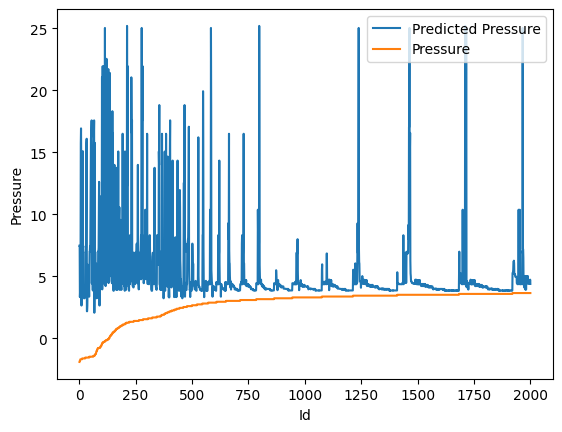

In [37]:
# preds_P = [row["upscaled_pred"] for row in preds_sample.collect()]
# test_P=[row["pressure"] for row in test_sample.collect()]
# Id = list(range(1, 2001))

# fig, ax = plt.subplots()
# # Plot id vs pressure 
# ax.plot(Id, preds_P, label="Predicted Pressure")
# ax.plot(Id, test_P, label="Pressure")
# #Set the x-axis and y-axis labels
# ax.set_xlabel("Id")
# ax.set_ylabel("Pressure")

# # Add a legend
# ax.legend(loc='upper right')

# # Show the plot
# plt.show()

In [38]:
# scaled_preds.show(5)

In [39]:
# computing EMSE,MSE, MAE and R2
evaluator = RegressionEvaluator(labelCol='pressure', metricName="rmse",predictionCol='upscaled_pred')
rmse = evaluator.evaluate(scaled_preds, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(scaled_preds, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(scaled_preds, {evaluator.metricName: "r2"})

In [40]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {rmse*rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 4.1783801312727045
Mean Squared Error (MSE): 17.458860521414504
Mean Absolute Error (MAE): 2.1628121281816757
R-squared (R2): 0.7347331391381069
